## 목적 : 24년도 고객중 누가 이탈할 것인가, 누가 재구매할 것인가
### 1. RFM기준으로  이탈예측을 하면 어떻게 될까?
### 이탈의 기준 90일 이상 방문하지 않은 것
### 방법1. 마지막날 시점으로 이탈한 고객과 그렇지 않은 고객 분류 
### 방법2. 랜덤포레스트로 예측 : 학습(2023년) > 예측 2024년
### 방법3. 2024년도 이탈예측 > RFM으로 분류(태블로)

In [2]:
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [3]:
look = pd.read_csv('C:/Users/LG/Desktop/데이터분석/프로젝트/최종프로젝트/3차/looker_(datetime).csv')

C:\Users\LG\AppData\Local\Temp\ipykernel_7900\1191939609.py:1: DtypeWarning: Columns (35) have mixed types. Specify dtype option on import or set low_memory=False.
  look = pd.read_csv('C:/Users/LG/Desktop/데이터분석/프로젝트/최종프로젝트/3차/looker_(datetime).csv')


In [4]:
def convert_type(df):
    for col in df.columns:
        if '_at' in col:    # 시간 데이터
            df = df.assign(**{col:pd.to_datetime(df[col], format='ISO8601')})
            print('[+] {0:<30} >>> datetime'.format(col))
        elif '_id' in col:  # id 컬럼 -> obj형으로
            df = df.assign(**{col:df[col].astype('object')})
            print('[+] {0:<30} >>> object'.format(col))
    return df

In [5]:
look = convert_type(look)

[+] user_id                        >>> object
[+] account_created_at             >>> datetime
[+] order_id                       >>> object
[+] order_items_id                 >>> object
[+] order_created_at               >>> datetime
[+] shipped_at                     >>> datetime
[+] delivered_at                   >>> datetime
[+] returned_at                    >>> datetime
[+] event_id                       >>> object
[+] session_id                     >>> object
[+] login_user_id                  >>> object
[+] sess_created_at                >>> datetime
[+] inventory_item_id              >>> object
[+] product_id                     >>> object
[+] inventory_created_at           >>> datetime
[+] inventory_sold_at              >>> datetime


In [6]:
df = look.copy()

In [7]:
df['year'] = df['sess_created_at'].dt.year

In [8]:
# 이탈고객 구하기 : 비회원 제거 > 최근날짜 - 마지막 주문일 이 90을 초과할 경우 이탈
# sess_created_at - now > 90 이상일 경우 이탈 , 이탈고객 정리하기, 이탈이면 1
# 이탈이면 1 아니면 0
df = df.dropna(subset=['user_id'])
maxdate = df['sess_created_at'].max()+dt.timedelta(days=1)
diff = df.groupby(['user_id']).agg({'sess_created_at':lambda x :(maxdate-max(x)).days})
churn = diff.map(lambda x :1 if x > 90 else 0).reset_index()
churn.rename(columns={'sess_created_at':'churn'},inplace=True) 
churn

,user_id,churn
0,1.0,1
1,2.0,1
2,3.0,1
3,4.0,1
4,5.0,1
...,...,...
96869,99996.0,1
96870,99997.0,0
96871,99998.0,1
96872,99999.0,0


In [9]:
# df와 churn 합치기
df = pd.merge(df,churn,on='user_id',how='inner')

In [10]:
df['churn'].value_counts()

churn
1    103343
0     62500
Name: count, dtype: int64

In [11]:
df23 = df[df['year']==2023]

In [12]:
# 24년도 방문한 고객중 이탈고객은 아무도 없음 -> 당연
df[df['year']==2024]['churn'].value_counts()

churn
0    10862
Name: count, dtype: int64

In [13]:
df23.info()

<class 'pandas.core.frame.DataFrame'>
Index: 68488 entries, 0 to 165842
Data columns (total 39 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   user_id                 68488 non-null  object             
 1   age                     68488 non-null  float64            
 2   gender                  68488 non-null  object             
 3   account_state           68488 non-null  object             
 4   account_city            67849 non-null  object             
 5   account_country         68488 non-null  object             
 6   latitude                68488 non-null  float64            
 7   longitude               68488 non-null  float64            
 8   account_traffic_source  68488 non-null  object             
 9   account_created_at      68488 non-null  datetime64[ns]     
 10  order_id                68488 non-null  object             
 11  order_items_id          68488 non-null  objec

### 학습할 픽처 정하기
- (age),gender,	account_state,account_traffic_source,(account_created_at),status,sale_price, (sequence_number) ,(order_created_at,delivered_at) 
1.전처리 : age -> 연령대로 만들기
2. 전처리 : diliver - order_created_at > 주문 배송시간의 차이 구하기 : 배송소요시간
3. 전처리 : sequence_number > 아이디당 총 개수(아이디당 클릭수)
4. 전처리 : account_created_at > 가입연도,월로 변경
5. 전처리 : sess_created_at - now > 90 이상일 경우 이탈

In [14]:
#1. age > 연령대로 바꾸기
def change_age(age):
    if age < 10:
        return 10
    elif 10<= age <20:
        return 10
    elif 20<= age <30:
        return 20
    elif 30<= age <40:
        return 30
    elif 40<= age <50:
        return 40
    elif 50<= age <60:
        return 50
    else:
        return 60
df23['age'] = df23['age'].apply(change_age)

C:\Users\LG\AppData\Local\Temp\ipykernel_7900\1820989220.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df23['age'] = df23['age'].apply(change_age)


In [15]:
# 반영안함 : 주문완료가 안된것이 너무 많음 > 대체처리가 어렵..
# 2. diliver - order_created_at > 주문 배송시간의 차이 구하기 : 배송소요시간
# https://engineer-mole.tistory.com/311
# a = df23['delivered_at'] - df23['order_created_at']
# df23['ship_days'] = a.dt.days

In [16]:
# 반영 안함 : 24년도 고객에게 적용하기 부적합 
# #4.account_created_at > 가입연도,월로 변경
# from datetime import datetime
# df23['accountYM'] = df23['account_created_at'].dt.strftime('%Y%m')
# df23['accountYM'] = df23['accountYM'].astype(float)

In [17]:
df23.head(3)

,user_id,age,gender,account_state,account_city,account_country,latitude,longitude,account_traffic_source,account_created_at,...,inventory_item_id,product_id,category,brand,product_name,inventory_created_at,inventory_sold_at,cost,year,churn
0,76411.0,50,F,Heilongjiang,Wenzhou,China,45.713922,126.769299,Search,2023-06-30,...,375421.0,14215.0,Accessories,Aquapro,Radiant Navy Blue Pleated Turban Hat Head Cove...,2023-11-03,NaT,2.60352,2023.0,1
3,58580.0,60,M,Sichuan,Shenzhen,China,30.753098,104.044969,Email,2023-06-23,...,287340.0,25859.0,Underwear,Dockers,Dockers Men's Performance V-Neck T-Shirt,2022-01-20,NaT,8.51700,2023.0,0
5,74726.0,20,F,Ceará,Fortaleza,Brasil,-3.716643,-38.558031,Search,2023-10-08,...,367388.0,1643.0,Fashion Hoodies & Sweatshirts,Volcom,Volcom Juniors Stone Stade Hydro Zip Sweater,2022-04-29,NaT,26.89400,2023.0,0


In [18]:
# 1차 전처리 확인
df23_1 = df23[['user_id','order_id','age','gender','account_traffic_source','status','sale_price','sess_traffic_source','sess_created_at','sequence_number','churn']]

In [19]:
df23_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 68488 entries, 0 to 165842
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   user_id                 68488 non-null  object             
 1   order_id                68488 non-null  object             
 2   age                     68488 non-null  int64              
 3   gender                  68488 non-null  object             
 4   account_traffic_source  68488 non-null  object             
 5   status                  68488 non-null  object             
 6   sale_price              68488 non-null  float64            
 7   sess_traffic_source     68488 non-null  object             
 8   sess_created_at         68488 non-null  datetime64[ns, UTC]
 9   sequence_number         68488 non-null  float64            
 10  churn                   68488 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(2), int64(

In [20]:
# 2차 전처리 : 오브제  > 수치형
# get_dummies : gender(2) , status(5) ,sess_traffic_source(5)
# labeling : account_traffic_source(5)
# -> 나중에 유저당 1개의 행으로 만들기 위해 합을 구할 것
# https://velog.io/@jiazzang/%EB%8D%B0%EC%9D%B4%ED%84%B0-%EC%A0%84%EC%B2%98%EB%A6%AC-%EB%8D%B0%EC%9D%B4%ED%84%B0-%EC%9D%B8%EC%BD%94%EB%94%A9Label-encoding-One-Hot-encoding

In [21]:
# 성별 전처리(f,m -> 첫행 제거) : M = true F = False 
df23_1['gender'] = pd.get_dummies(df23_1['gender'],drop_first=True) 

C:\Users\LG\AppData\Local\Temp\ipykernel_7900\1006465041.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df23_1['gender'] = pd.get_dummies(df23_1['gender'],drop_first=True)


In [22]:
# 상태 전처리
dummy = pd.get_dummies(df23_1['status'], columns=['Cancelled','Complete','Processing','Returned','Shipped'])
df23_1['Cancelled'] = dummy['Cancelled']
df23_1['Complete'] = dummy['Complete']
df23_1['Processing'] = dummy['Processing']
df23_1['Returned'] = dummy['Returned']
df23_1['Shipped'] = dummy['Shipped']

C:\Users\LG\AppData\Local\Temp\ipykernel_7900\2417626514.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df23_1['Cancelled'] = dummy['Cancelled']
C:\Users\LG\AppData\Local\Temp\ipykernel_7900\2417626514.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df23_1['Complete'] = dummy['Complete']
C:\Users\LG\AppData\Local\Temp\ipykernel_7900\2417626514.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

In [23]:
# sess_traffic_source = Adwords	Email	Facebook	Organic	YouTube
dummy1 = pd.get_dummies(df23_1['sess_traffic_source'], columns=['Adwords','Email','Facebook','Organi','YouTube'])
df23_1['Adwords'] = dummy1['Adwords']
df23_1['Email'] = dummy1['Email']
df23_1['Facebook'] = dummy1['Facebook']
df23_1['Organic'] = dummy1['Organic']
df23_1['YouTube'] = dummy1['YouTube']

C:\Users\LG\AppData\Local\Temp\ipykernel_7900\3697836073.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df23_1['Adwords'] = dummy1['Adwords']
C:\Users\LG\AppData\Local\Temp\ipykernel_7900\3697836073.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df23_1['Email'] = dummy1['Email']
C:\Users\LG\AppData\Local\Temp\ipykernel_7900\3697836073.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

In [24]:
# 가입경로는 1개이까 라벨링으로
from sklearn.preprocessing import LabelEncoder
la = LabelEncoder()
df23_1['account_traffic_source'] = la.fit_transform(df23_1['account_traffic_source'])

C:\Users\LG\AppData\Local\Temp\ipykernel_7900\779499935.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df23_1['account_traffic_source'] = la.fit_transform(df23_1['account_traffic_source'])


In [25]:
df23_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 68488 entries, 0 to 165842
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   user_id                 68488 non-null  object             
 1   order_id                68488 non-null  object             
 2   age                     68488 non-null  int64              
 3   gender                  68488 non-null  bool               
 4   account_traffic_source  68488 non-null  int32              
 5   status                  68488 non-null  object             
 6   sale_price              68488 non-null  float64            
 7   sess_traffic_source     68488 non-null  object             
 8   sess_created_at         68488 non-null  datetime64[ns, UTC]
 9   sequence_number         68488 non-null  float64            
 10  churn                   68488 non-null  int64              
 11  Cancelled               68488 non-null  bool 

In [26]:
# 2차 전처리 : 총클릭수, 총 구매액, 총 취소주문개수, 총 환불진행개수, 총진행주문개수, 총배송주문개수, 총완료주문개수

In [27]:
# 총클릭수
c = df23_1.groupby(['user_id','order_id'],as_index=False)['sequence_number'].max()
click = c.groupby(['user_id'],as_index=False)['sequence_number'].sum()
click.rename(columns = {'sequence_number':'total_click'},inplace=True)

In [28]:
# 총구매액
total_price = df23_1.groupby(['user_id'],as_index=False)['sale_price'].sum()
total_price.rename(columns = {'sale_price':'total_price'},inplace=True)

In [29]:
# 총 유입경로의 개수
traffic = df23_1.groupby(['user_id'])[['Adwords','Email','Facebook','Organic','YouTube']].sum()
traffic

,Adwords,Email,Facebook,Organic,YouTube
user_id,,,,,
3.0,0,4,0,0,0
9.0,2,0,0,0,0
11.0,1,0,0,0,0
12.0,2,0,1,1,0
16.0,0,1,0,0,0
...,...,...,...,...,...
99988.0,1,0,0,0,0
99989.0,1,1,0,0,0
99996.0,0,0,2,0,0


In [30]:
# 총 취소주문개수, 총 환불진행개수, 총진행주문개수, 총배송주문개수, 총완료주문개수
stats= df23_1.groupby(['user_id'])[['Cancelled','Complete','Processing','Returned','Shipped']].sum()
stats

,Cancelled,Complete,Processing,Returned,Shipped
user_id,,,,,
3.0,0,1,2,0,1
9.0,2,0,0,0,0
11.0,0,0,0,0,1
12.0,0,0,2,1,1
16.0,0,0,0,0,1
...,...,...,...,...,...
99988.0,1,0,0,0,0
99989.0,0,0,2,0,0
99996.0,0,0,2,0,0


In [31]:
# 모든 전처리의 값 합치기
a = pd.merge(click,total_price,on='user_id',how='inner')
b = pd.merge(a,traffic,on='user_id',how='inner')
c = pd.merge(b,stats,on='user_id',how='inner')
d = df23_1[['user_id','gender','age','churn','account_traffic_source']].drop_duplicates(subset=['user_id'])
# 기존 df23_1에서 중복 제거하기
df23_final = pd.merge(c,d,on='user_id',how='inner')

In [32]:
df23_final

,user_id,total_click,total_price,Adwords,Email,Facebook,Organic,YouTube,Cancelled,Complete,Processing,Returned,Shipped,gender,age,churn,account_traffic_source
0,3.0,22.0,338.230000,0,4,0,0,0,0,1,2,0,1,True,10,1,3
1,9.0,7.0,71.950001,2,0,0,0,0,2,0,0,0,0,True,30,0,3
2,11.0,5.0,45.349998,1,0,0,0,0,0,0,0,0,1,False,40,0,3
3,12.0,17.0,141.060001,2,0,1,1,0,0,0,2,1,1,False,40,1,4
4,16.0,5.0,16.790001,0,1,0,0,0,0,0,0,0,1,True,60,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42352,99988.0,5.0,68.000000,1,0,0,0,0,1,0,0,0,0,True,60,1,4
42353,99989.0,7.0,15.120000,1,1,0,0,0,0,0,2,0,0,False,30,1,4
42354,99996.0,7.0,62.870001,0,0,2,0,0,0,0,2,0,0,True,50,1,4
42355,99998.0,10.0,76.990000,1,1,0,0,0,0,0,2,0,0,True,50,1,4


In [33]:
# 유저아이디/ 이탈여부 분리하기
user23 = df23_final.pop('user_id')
target = df23_final.pop('churn')

In [34]:
# 성능평가를 위한 분류
from sklearn.model_selection import train_test_split
x_train, X_test, Y_train, Y_test = train_test_split(df23_final, target, random_state = 42)

In [35]:
#모델링
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state = 42,max_depth=5,n_estimators=500)
model.fit(x_train,  Y_train)
Y_test_pre = model.predict(X_test)

In [37]:
from sklearn.metrics import f1_score
f1 = f1_score(Y_test,Y_test_pre)
f1

0.7925833184284267


In [38]:
# none parameter : 0.7053206946654674 
# max_depth=5 :0.7913454067300221
# max_depth=5,n_estimators=200 : 0.7919599188834546
# max_depth=5,n_estimators=300 : 0.7921961696796134
# (최종) max_depth=5,n_estimators=300 :0.7925833184284267
# max_depth=6 : 0.7906614785992218

### 24년도 user_idf로 예측하기

In [40]:
df24 = df[df['year']==2024]

In [41]:
df24 = df24[['user_id','order_id','age','gender','account_traffic_source','status','sale_price','sess_traffic_source','sess_created_at','sequence_number']]

In [42]:
#1. age > 연령대로 바꾸기
def change_age(age):
    if age < 10:
        return 10
    elif 10<= age <20:
        return 10
    elif 20<= age <30:
        return 20
    elif 30<= age <40:
        return 30
    elif 40<= age <50:
        return 40
    elif 50<= age <60:
        return 50
    else:
        return 60
df24['age'] = df24['age'].apply(change_age)

In [43]:
# 성별 전처리(f,m -> 첫행 제거) : M = true F = False 
df24['gender'] = pd.get_dummies(df24['gender'],drop_first=True) 

In [44]:
# 상태 전처리
dummy = pd.get_dummies(df24['status'], columns=['Cancelled','Complete','Processing','Returned','Shipped'])
df24['Cancelled'] = dummy['Cancelled']
df24['Complete'] = dummy['Complete']
df24['Processing'] = dummy['Processing']
df24['Returned'] = dummy['Returned']
df24['Shipped'] = dummy['Shipped']

In [45]:
# 유입경로 전처리
# sess_traffic_source = Adwords	Email	Facebook	Organic	YouTube
dummy1 = pd.get_dummies(df24['sess_traffic_source'], columns=['Adwords','Email','Facebook','Organi','YouTube'])
df24['Adwords'] = dummy1['Adwords']
df24['Email'] = dummy1['Email']
df24['Facebook'] = dummy1['Facebook']
df24['Organic'] = dummy1['Organic']
df24['YouTube'] = dummy1['YouTube']

In [46]:
la = LabelEncoder()
df24['account_traffic_source'] = la.fit_transform(df24['account_traffic_source'])

In [47]:
# 총클릭수
c = df24.groupby(['user_id','order_id'],as_index=False)['sequence_number'].max()
click = c.groupby(['user_id'],as_index=False)['sequence_number'].sum()
click.rename(columns = {'sequence_number':'total_click'},inplace=True)

In [48]:
# 총구매액
total_price = df24.groupby(['user_id'],as_index=False)['sale_price'].sum()
total_price.rename(columns = {'sale_price':'total_price'},inplace=True)

In [49]:
# 총 유입경로의 개수
traffic = df24.groupby(['user_id'])[['Adwords','Email','Facebook','Organic','YouTube']].sum()
traffic

,Adwords,Email,Facebook,Organic,YouTube
user_id,,,,,
11.0,1,0,0,0,0
13.0,1,1,0,0,0
22.0,0,0,0,1,0
26.0,1,0,0,0,0
45.0,1,0,1,0,0
...,...,...,...,...,...
99964.0,0,0,1,0,0
99968.0,0,0,1,0,0
99970.0,0,1,0,0,0


In [50]:
# 총 취소주문개수, 총 환불진행개수, 총진행주문개수, 총배송주문개수, 총완료주문개수
stats= df24.groupby(['user_id'])[['Cancelled','Complete','Processing','Returned','Shipped']].sum()
stats

,Cancelled,Complete,Processing,Returned,Shipped
user_id,,,,,
11.0,0,0,0,1,0
13.0,0,0,1,0,1
22.0,0,0,1,0,0
26.0,0,0,1,0,0
45.0,0,0,1,0,1
...,...,...,...,...,...
99964.0,0,0,1,0,0
99968.0,0,0,1,0,0
99970.0,0,1,0,0,0


In [51]:
# 모든 전처리의 값 합치기
a = pd.merge(click,total_price,on='user_id',how='inner')
b = pd.merge(a,traffic,on='user_id',how='inner')
c = pd.merge(b,stats,on='user_id',how='inner')
d = df24[['user_id','gender','age','account_traffic_source']].drop_duplicates(subset=['user_id'])
# 기존 df23_1에서 중복 제거하기
df24_final = pd.merge(c,d,on='user_id',how='inner')

In [52]:
df24_final

,user_id,total_click,total_price,Adwords,Email,Facebook,Organic,YouTube,Cancelled,Complete,Processing,Returned,Shipped,gender,age,account_traffic_source
0,11.0,5.0,132.000000,1,0,0,0,0,0,0,0,1,0,False,40,3
1,13.0,10.0,127.950001,1,1,0,0,0,0,0,1,0,1,False,50,4
2,22.0,5.0,43.000000,0,0,0,1,0,0,0,1,0,0,True,20,3
3,26.0,5.0,29.950001,1,0,0,0,0,0,0,1,0,0,False,30,4
4,45.0,10.0,111.990002,1,0,1,0,0,0,0,1,0,1,False,10,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6838,99964.0,5.0,25.900000,0,0,1,0,0,0,0,1,0,0,False,50,4
6839,99968.0,5.0,13.000000,0,0,1,0,0,0,0,1,0,0,False,10,4
6840,99970.0,5.0,9.990000,0,1,0,0,0,0,1,0,0,0,False,20,4
6841,99971.0,10.0,244.989998,0,2,0,0,1,3,0,0,0,0,True,20,4


In [53]:
# 분류를 위해 id분리하기
user24 = df24_final.pop('user_id')

In [54]:
df24_final

,total_click,total_price,Adwords,Email,Facebook,Organic,YouTube,Cancelled,Complete,Processing,Returned,Shipped,gender,age,account_traffic_source
0,5.0,132.000000,1,0,0,0,0,0,0,0,1,0,False,40,3
1,10.0,127.950001,1,1,0,0,0,0,0,1,0,1,False,50,4
2,5.0,43.000000,0,0,0,1,0,0,0,1,0,0,True,20,3
3,5.0,29.950001,1,0,0,0,0,0,0,1,0,0,False,30,4
4,10.0,111.990002,1,0,1,0,0,0,0,1,0,1,False,10,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6838,5.0,25.900000,0,0,1,0,0,0,0,1,0,0,False,50,4
6839,5.0,13.000000,0,0,1,0,0,0,0,1,0,0,False,10,4
6840,5.0,9.990000,0,1,0,0,0,0,1,0,0,0,False,20,4
6841,10.0,244.989998,0,2,0,0,1,3,0,0,0,0,True,20,4


In [55]:
#모델링
pre_24 = model.predict(df24_final)

In [56]:
churnid_24 = pd.DataFrame({'id':user24,'Target':pre_24})
# churnid_24.to_csv('churnid_24.csv',index=False)

In [57]:
churnid_24['Target'].value_counts()

Target
1    6362
0     481
Name: count, dtype: int64

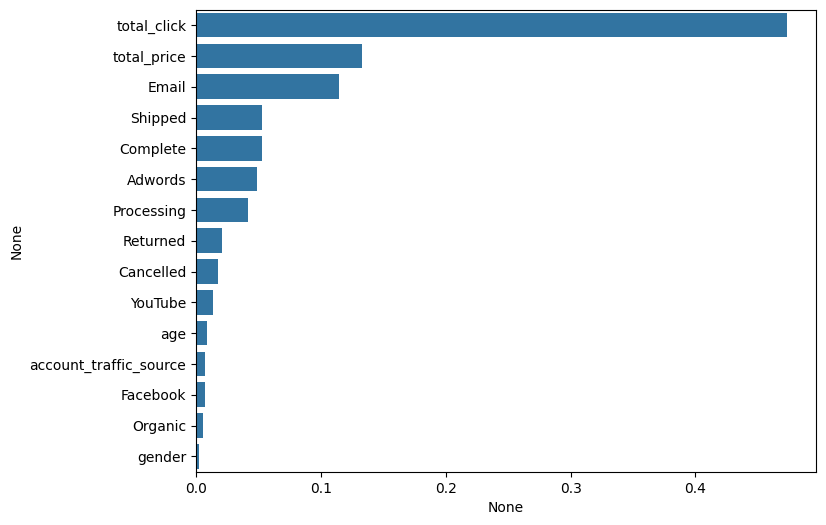

In [58]:
import matplotlib as mpl
import matplotlib.font_manager as fm
 
ftr_importances_values = model.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=x_train.columns)
ftr_top = ftr_importances.sort_values(ascending=False)[:20]
 
plt.figure(figsize=(8, 6))
sns.barplot(x=ftr_top, y=ftr_top.index)
plt.show()

In [59]:
model.feature_importances_

array([0.4729489 , 0.13302611, 0.0491104 , 0.11473361, 0.00682218,
       0.0053188 , 0.01397341, 0.01782891, 0.05283272, 0.04179945,
       0.0204315 , 0.05293593, 0.00229701, 0.00876175, 0.00717933])

In [60]:
pd.set_option('display.max_columns',100)

In [61]:
# # 같은 주문일 경우 sequence_number 가 같다
# # 총 클릭수를 계산하기 위해서는 order_id별로 sequence_number의 max값을 구해서 합한다
# e = df23.groupby(['user_id','order_id'],as_index=False)['sequence_number'].max()
# e.groupby(['user_id'],as_index=False)['sequence_number'].sum()

In [62]:
# order = pd.read_csv('C:/Users/LG/Desktop/데이터분석/프로젝트/최종프로젝트/3차/order_items.csv')

In [63]:
# order = convert_type(order)

In [64]:
# order[order['user_id']==98276].sort_values('created_at')

In [65]:
# q = order[(order['status']=='Shipped')|(order['status']=='Complete')][['status','delivered_at']].dropna()
# q[q['status']=='Shipped']
# ## Shipped는 배송완료가 아님

In [66]:
# order[order['status']=='Complete']